# Historical Options Data: EDA and Feature Engineering

## Pipeline Overview
1. **Data Loading**: Load cleaned historical-style options data
2. **Black-Scholes Analysis**: Calculate theoretical prices with robust error handling
3. **Feature Engineering**: Create ML-ready features
4. **Distribution Analysis**: Visualize key variable distributions
5. **Correlation Analysis**: Identify relationships between variables
6. **Outlier Detection**: Flag anomalous observations
7. **Data Export**: Save enhanced dataset for modeling


In [ ]:
import sys
import os
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import glob
import warnings
warnings.filterwarnings('ignore')

from config import Config
from black_scholes import BlackScholesCalculator
from data_processor import OptionsDataProcessor

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)


In [ ]:
# cleaned data
data_files = glob.glob('data/processed/cleaned_options_data_*.csv')
if not data_files:
    raise FileNotFoundError("No cleaned data files found")

latest_file = max(data_files, key=os.path.getctime)
df = pd.read_csv(latest_file)

# datetime columns
datetime_cols = ['expiration_date', 'fetch_timestamp', 'simulated_trade_date']
for col in datetime_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col])

print(f"Dataset loaded: {latest_file}")
print(f"Shape: {df.shape}")
print(f"Contracts by type: {df['contract_type'].value_counts().to_dict()}")


Dataset loaded: data/processed\cleaned_options_data_20250823_164021.csv
Shape: (457, 19)
Contracts by type: {'put': 233, 'call': 224}


In [ ]:
# Black-Scholes Analysis
bs_calculator = BlackScholesCalculator()
processor = OptionsDataProcessor()

print("Calculating Black-Scholes prices...")
bs_prices = []

for _, row in df.iterrows():
    try:
        # edge cases
        if (row['time_to_expiry'] <= 0 or row['implied_volatility'] <= 0 or 
            row['strike'] <= 0 or row['underlying_price'] <= 0):
            bs_prices.append(np.nan)
            continue
            
        # Price based on option type
        if row['contract_type'] == 'call':
            bs_price = bs_calculator.call_price(
                S=row['underlying_price'],
                K=row['strike'],
                T=row['time_to_expiry'],
                r=row['risk_free_rate'],
                sigma=row['implied_volatility']
            )
        else:  # put
            bs_price = bs_calculator.put_price(
                S=row['underlying_price'],
                K=row['strike'],
                T=row['time_to_expiry'],
                r=row['risk_free_rate'],
                sigma=row['implied_volatility']
            )
        bs_prices.append(bs_price)
    except Exception as e:
        bs_prices.append(np.nan)

df_analysis = processor.calculate_target_variable(df, pd.Series(bs_prices))

df_analysis['abs_pricing_error'] = np.abs(df_analysis['pricing_error'])
df_analysis['relative_error_robust'] = np.where(
    (df_analysis['bs_price'] > 0.01) & (df_analysis['time_to_expiry'] > 0.01),  # Filter criteria
    np.abs(df_analysis['pricing_error'] / df_analysis['bs_price']) * 100,
    np.nan
)

valid_mask = (~df_analysis['pricing_error'].isna()) & (~df_analysis['bs_price'].isna())
valid_df = df_analysis[valid_mask].copy()

print(f"Black-Scholes Analysis (robust):")
print(f"Valid calculations: {valid_mask.sum()}/{len(df_analysis)}")
print(f"Mean absolute pricing error: ${valid_df['abs_pricing_error'].mean():.4f}")
print(f"Median absolute error: ${valid_df['abs_pricing_error'].median():.4f}")
print(f"Mean relative error (filtered): {valid_df['relative_error_robust'].mean():.2f}%")
print(f"Median relative error (filtered): {valid_df['relative_error_robust'].median():.2f}%")

print(f"\nSample results:")
sample_cols = ['strike', 'contract_type', 'market_price', 'bs_price', 'pricing_error', 'abs_pricing_error']
print(valid_df[sample_cols].head().round(6))


Calculating Black-Scholes prices...
Black-Scholes Analysis (robust):
Valid calculations: 457/457
Mean absolute pricing error: $1.7761
Median absolute error: $0.0438
Mean relative error (filtered): 48.49%
Median relative error (filtered): 1.73%

Sample results:
   strike contract_type  market_price    bs_price  pricing_error  \
0   530.0          call       115.380  115.369375       0.010625   
1   550.0          call        95.385   95.371626       0.013374   
2   570.0          call        75.390   75.373887       0.016113   
3   580.0          call        65.395   65.425774      -0.030774   
4   590.0          call        55.395   55.436480      -0.041480   

   abs_pricing_error  
0           0.010625  
1           0.013374  
2           0.016113  
3           0.030774  
4           0.041480  


In [ ]:
# Feature Engineering
print("Engineering features...")

# Market microstructure features
df_analysis['bid_ask_spread'] = df_analysis['ask'] - df_analysis['bid']
df_analysis['relative_spread'] = df_analysis['bid_ask_spread'] / df_analysis['market_price']

# Options-specific features
df_analysis['log_moneyness'] = np.log(df_analysis['underlying_price'] / df_analysis['strike'])
df_analysis['sqrt_time'] = np.sqrt(df_analysis['time_to_expiry'])
df_analysis['vega_proxy'] = df_analysis['underlying_price'] * df_analysis['sqrt_time'] * df_analysis['implied_volatility']

# Liquidity features
df_analysis['liquidity_score'] = np.log1p(df_analysis['volume']) + np.log1p(df_analysis['open_interest'])

# Binary features
df_analysis['is_call'] = (df_analysis['contract_type'] == 'call').astype(int)
df_analysis['is_put'] = (df_analysis['contract_type'] == 'put').astype(int)

# Moneyness categories
df_analysis['itm'] = (
    ((df_analysis['contract_type'] == 'call') & (df_analysis['moneyness'] > 1.02)) |
    ((df_analysis['contract_type'] == 'put') & (df_analysis['moneyness'] < 0.98))
).astype(int)

df_analysis['otm'] = (
    ((df_analysis['contract_type'] == 'call') & (df_analysis['moneyness'] < 0.98)) |
    ((df_analysis['contract_type'] == 'put') & (df_analysis['moneyness'] > 1.02))
).astype(int)

df_analysis['atm'] = (
    (df_analysis['moneyness'] >= 0.98) & (df_analysis['moneyness'] <= 1.02)
).astype(int)

print("New features created:")
new_features = ['bid_ask_spread', 'relative_spread', 'log_moneyness', 'sqrt_time', 
                'vega_proxy', 'liquidity_score', 'is_call', 'is_put', 'itm', 'otm', 'atm']
print(f"Features: {new_features}")
print(f"\nFeature statistics:")
print(df_analysis[new_features].describe().round(4))


Engineering features...
New features created:
Features: ['bid_ask_spread', 'relative_spread', 'log_moneyness', 'sqrt_time', 'vega_proxy', 'liquidity_score', 'is_call', 'is_put', 'itm', 'otm', 'atm']

Feature statistics:
       bid_ask_spread  relative_spread  log_moneyness  sqrt_time  vega_proxy  \
count        457.0000         457.0000       457.0000   457.0000    457.0000   
mean           0.7582           0.5941         0.2572     0.1312     51.0450   
std            1.2154           0.8208         0.2573     0.0671     51.8427   
min            0.0100           0.0008        -0.0164     0.0523      0.0008   
25%            0.0100           0.0132         0.0481     0.0740     11.0837   
50%            0.0100           0.1027         0.1782     0.1047     32.7215   
75%            2.5600           0.6667         0.3944     0.1813     77.8884   
max            3.5100           2.0000         1.0761     0.2669    287.1903   

       liquidity_score   is_call    is_put       itm       

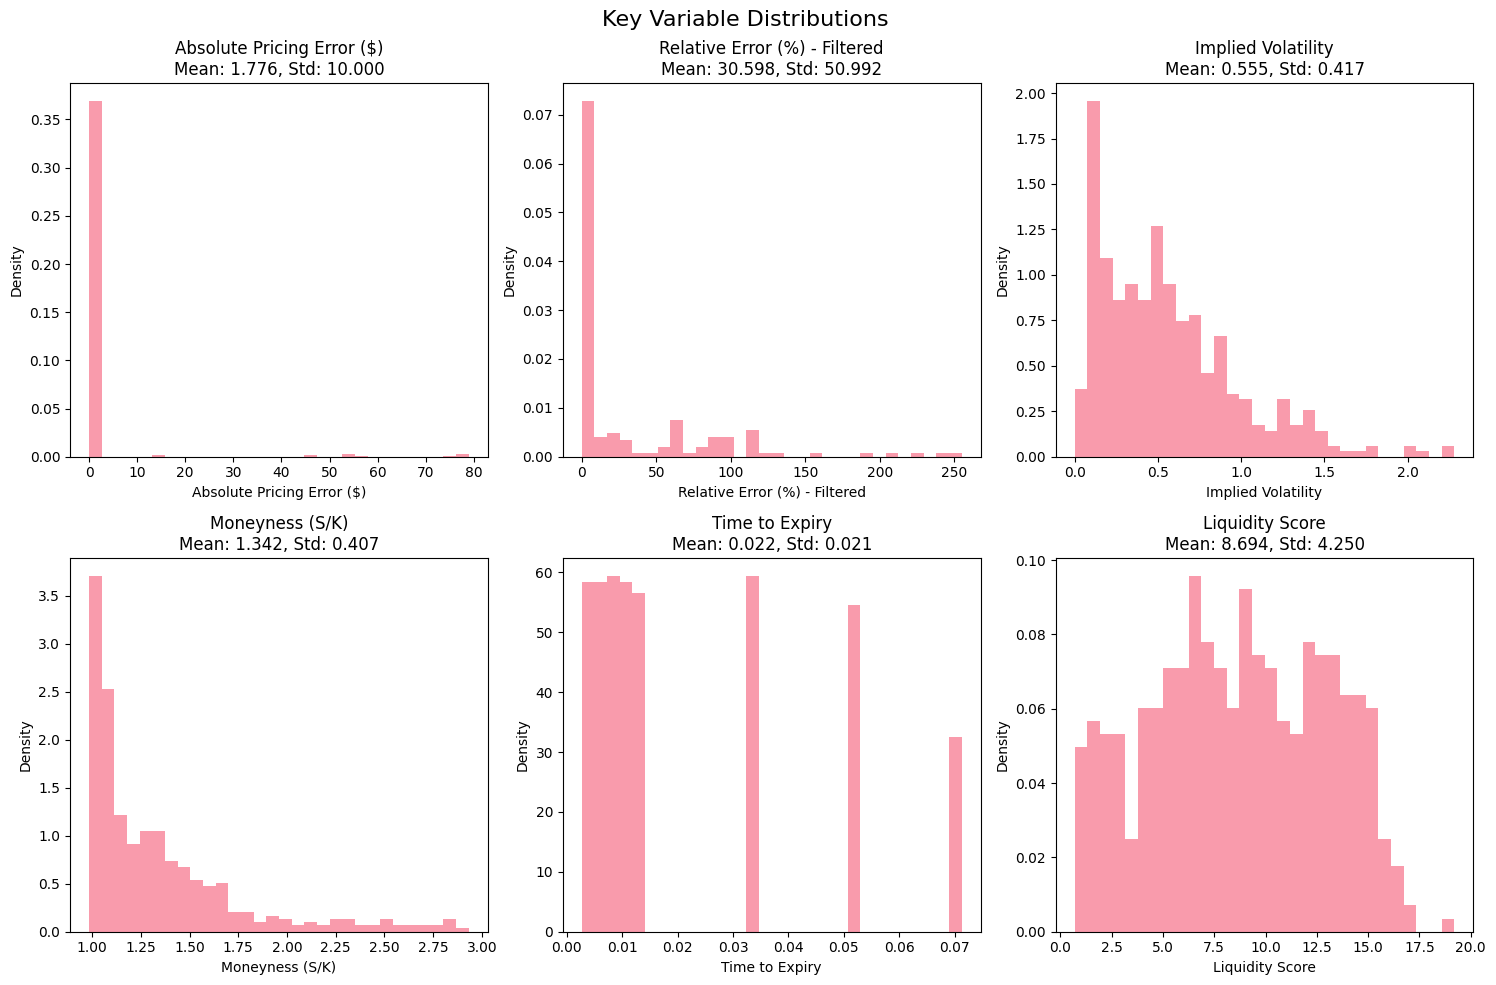

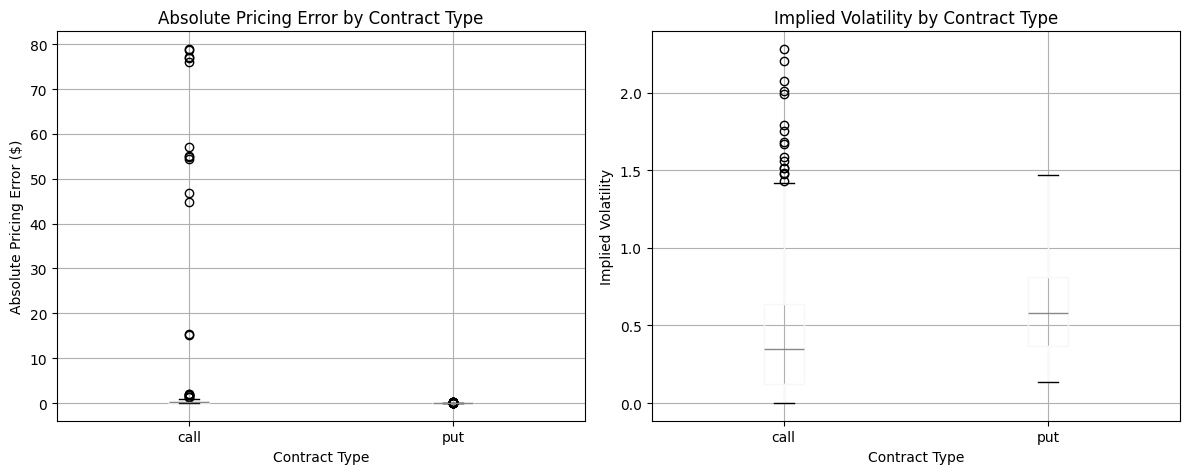

In [ ]:
# Distribution Analysis - Visualize key variables
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Key Variable Distributions', fontsize=16)

plot_vars = [
    ('abs_pricing_error', 'Absolute Pricing Error ($)'),
    ('relative_error_robust', 'Relative Error (%) - Filtered'),
    ('implied_volatility', 'Implied Volatility'),
    ('moneyness', 'Moneyness (S/K)'),
    ('time_to_expiry', 'Time to Expiry'),
    ('liquidity_score', 'Liquidity Score')
]

for i, (var, title) in enumerate(plot_vars):
    ax = axes[i//3, i%3]
    
    # Filter out extreme values
    if var == 'relative_error_robust':
        plot_data = df_analysis[var].dropna()
        if len(plot_data) > 0:
            cap_value = plot_data.quantile(0.95)
            plot_data = plot_data[plot_data <= cap_value]
    else:
        plot_data = df_analysis[var].dropna()
    
    if len(plot_data) > 0:
        ax.hist(plot_data, bins=30, alpha=0.7, density=True)
        ax.set_title(f'{title}\nMean: {plot_data.mean():.3f}, Std: {plot_data.std():.3f}')
        ax.set_xlabel(title)
        ax.set_ylabel('Density')
    else:
        ax.text(0.5, 0.5, 'No valid data', transform=ax.transAxes, ha='center')
        ax.set_title(title)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Absolute pricing error by contract type
df_analysis.boxplot(column='abs_pricing_error', by='contract_type', ax=axes[0])
axes[0].set_title('Absolute Pricing Error by Contract Type')
axes[0].set_xlabel('Contract Type')
axes[0].set_ylabel('Absolute Pricing Error ($)')

# Implied volatility by contract type
df_analysis.boxplot(column='implied_volatility', by='contract_type', ax=axes[1])
axes[1].set_title('Implied Volatility by Contract Type')
axes[1].set_xlabel('Contract Type')
axes[1].set_ylabel('Implied Volatility')

plt.suptitle('')
plt.tight_layout()
plt.show()


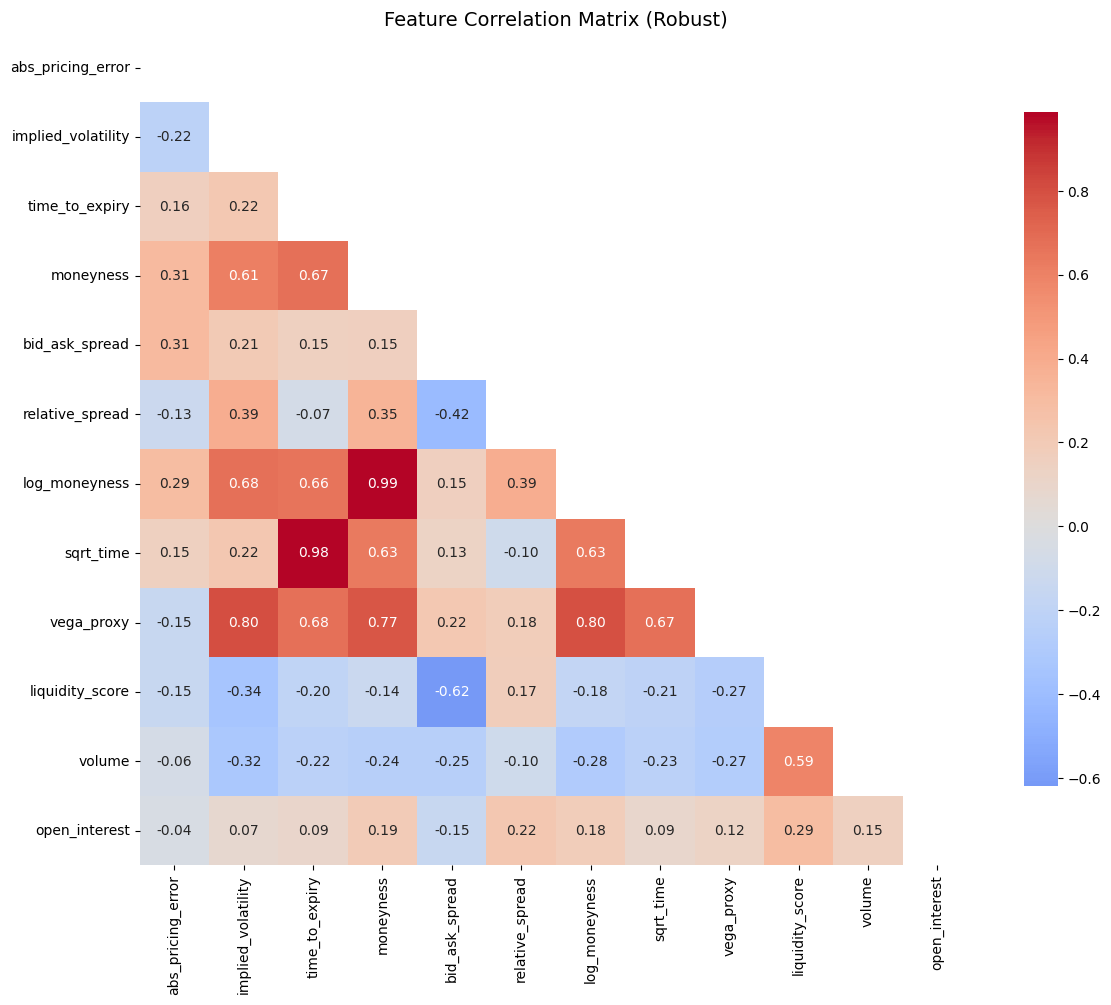

Top correlations with absolute pricing error:
  moneyness: 0.312
  bid_ask_spread: 0.310
  log_moneyness: 0.295
  implied_volatility: 0.216
  time_to_expiry: 0.158
  vega_proxy: 0.154
  sqrt_time: 0.147


In [ ]:
# Correlation Analysis
valid_mask_updated = (~df_analysis['pricing_error'].isna()) & (~df_analysis['bs_price'].isna())
valid_df_updated = df_analysis[valid_mask_updated].copy()

analysis_features = [
    'abs_pricing_error', 'implied_volatility', 'time_to_expiry', 'moneyness',
    'bid_ask_spread', 'relative_spread', 'log_moneyness', 'sqrt_time',
    'vega_proxy', 'liquidity_score', 'volume', 'open_interest'
]

# Calculate correlation matrix for valid data with all features
corr_data = valid_df_updated[analysis_features].corr()

# Correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_data, dtype=bool))
sns.heatmap(corr_data, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix (Robust)', fontsize=14)
plt.tight_layout()
plt.show()

# Top correlations with pricing error
print("Top correlations with absolute pricing error:")
pricing_error_corr = corr_data['abs_pricing_error'].abs().sort_values(ascending=False)
for feature, corr in pricing_error_corr.head(8).items():
    if feature != 'abs_pricing_error':
        print(f"  {feature}: {corr:.3f}")


Detecting outliers...
Outlier Detection Results:
Isolation Forest outliers: 411 (89.9%)
Pricing error outliers (IQR): 31 (6.8%)


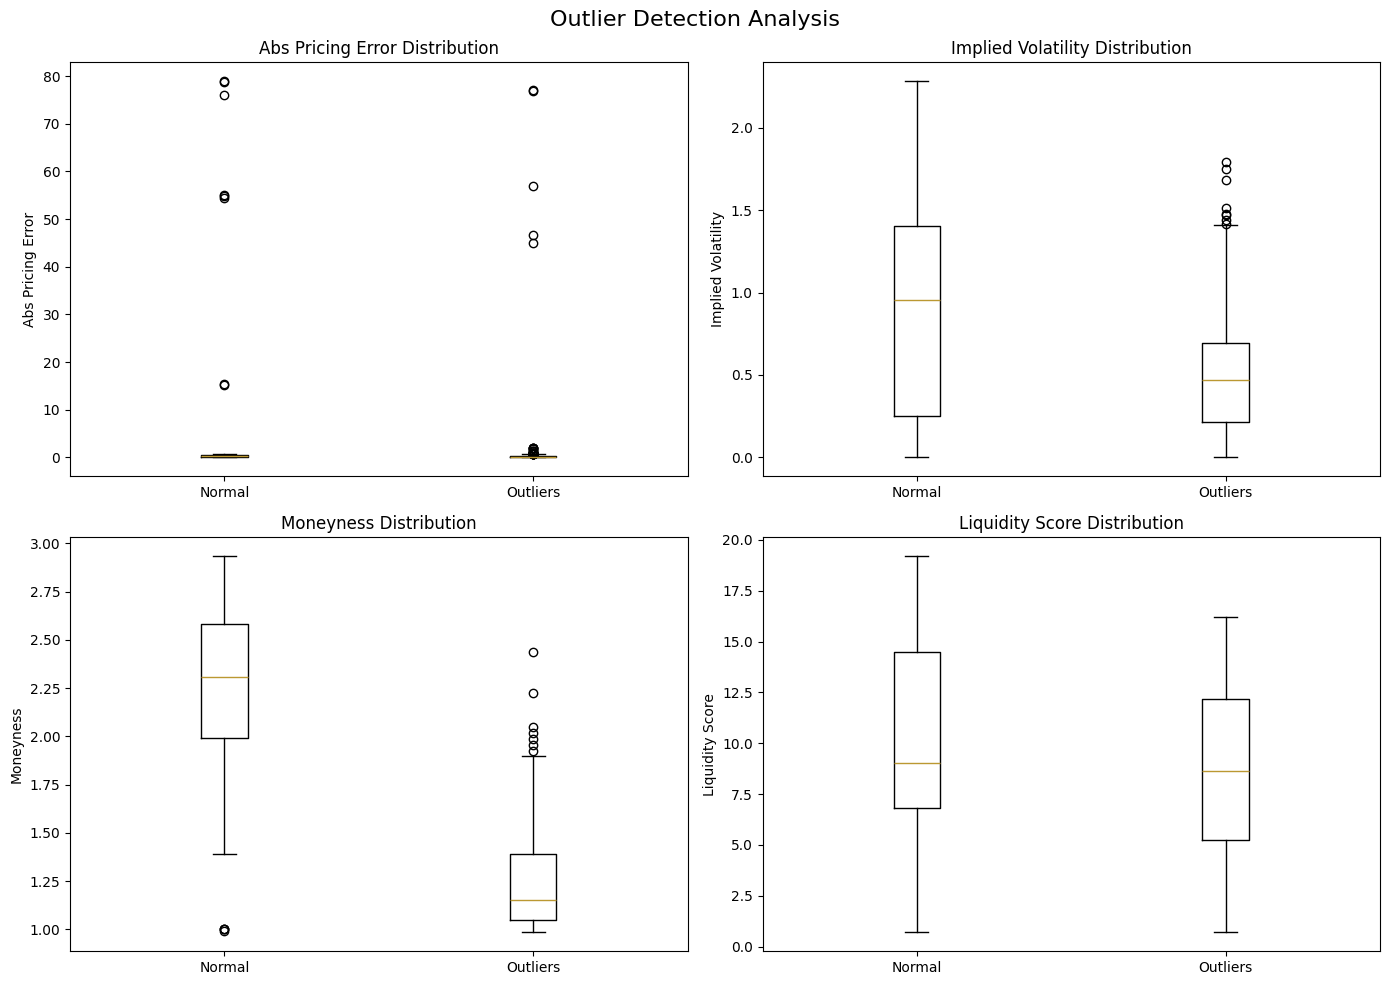


Top 10 absolute pricing error outliers:
  $240 call | Error: $78.938 | Money: 2.689 | TTM: 0.0712
  $255 call | Error: $78.676 | Money: 2.531 | TTM: 0.0712
  $340 call | Error: $77.160 | Money: 1.898 | TTM: 0.0137
  $350 call | Error: $76.946 | Money: 1.844 | TTM: 0.0137
  $390 call | Error: $75.963 | Money: 1.655 | TTM: 0.0137
  $430 call | Error: $56.991 | Money: 1.501 | TTM: 0.0137
  $225 call | Error: $55.009 | Money: 2.868 | TTM: 0.0712
  $235 call | Error: $54.943 | Money: 2.746 | TTM: 0.0712
  $270 call | Error: $54.420 | Money: 2.390 | TTM: 0.0712
  $385 call | Error: $46.726 | Money: 1.676 | TTM: 0.0137


In [ ]:
print("Outliers")

outlier_df, normal_df = processor.detect_outliers(valid_df_updated, method='isolation_forest')

valid_df_updated['outlier_iso'] = valid_df_updated.index.isin(outlier_df.index)

# IQR method 
Q1 = valid_df_updated['abs_pricing_error'].quantile(0.25)
Q3 = valid_df_updated['abs_pricing_error'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
valid_df_updated['outlier_pricing'] = (valid_df_updated['abs_pricing_error'] < lower_bound) | (valid_df_updated['abs_pricing_error'] > upper_bound)

print(f"Outlier Detection Results:")
print(f"Isolation Forest outliers: {valid_df_updated['outlier_iso'].sum()} ({valid_df_updated['outlier_iso'].mean()*100:.1f}%)")
print(f"Pricing error outliers (IQR): {valid_df_updated['outlier_pricing'].sum()} ({valid_df_updated['outlier_pricing'].mean()*100:.1f}%)")

# Visualize outliers for key features
outlier_features = ['abs_pricing_error', 'implied_volatility', 'moneyness', 'liquidity_score']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Outlier Detection Analysis', fontsize=16)

for i, feature in enumerate(outlier_features):
    ax = axes[i//2, i%2]
    
    # Box plot with outliers highlighted
    normal_data = valid_df_updated[~valid_df_updated['outlier_iso']][feature].dropna()
    outlier_data = valid_df_updated[valid_df_updated['outlier_iso']][feature].dropna()
    
    box_data = [normal_data, outlier_data]
    box_labels = ['Normal', 'Outliers']
    
    if len(normal_data) > 0 and len(outlier_data) > 0:
        ax.boxplot(box_data, labels=box_labels)
    elif len(normal_data) > 0:
        ax.boxplot([normal_data], labels=['Normal'])
    else:
        ax.text(0.5, 0.5, 'No data', transform=ax.transAxes, ha='center')
    
    ax.set_title(f'{feature.replace("_", " ").title()} Distribution')
    ax.set_ylabel(feature.replace('_', ' ').title())

plt.tight_layout()
plt.show()

print(f"\nTop 10 absolute pricing error outliers:")
top_outliers = valid_df_updated.nlargest(10, 'abs_pricing_error')[
    ['strike', 'contract_type', 'market_price', 'bs_price', 'abs_pricing_error', 'moneyness', 'time_to_expiry']
]
for _, row in top_outliers.iterrows():
    print(f"  ${row['strike']:.0f} {row['contract_type']} | "
          f"Error: ${row['abs_pricing_error']:.3f} | "
          f"Money: {row['moneyness']:.3f} | TTM: {row['time_to_expiry']:.4f}")


In [ ]:
# Final Dataset Summary and Export
print("="*50)
print("ROBUST DATASET SUMMARY")
print("="*50)

print(f"📊 Total observations: {len(df_analysis):,}")
print(f"📊 Valid BS calculations: {len(valid_df_updated):,} ({len(valid_df_updated)/len(df_analysis)*100:.1f}%)")
print(f"📊 Contracts by type: {valid_df_updated['contract_type'].value_counts().to_dict()}")

print(f"\n💰 Robust Pricing Analysis:")
print(f"   • Mean absolute error: ${valid_df_updated['abs_pricing_error'].mean():.4f}")
print(f"   • Median absolute error: ${valid_df_updated['abs_pricing_error'].median():.4f}")
print(f"   • 95th percentile error: ${valid_df_updated['abs_pricing_error'].quantile(0.95):.4f}")
print(f"   • Mean relative error (filtered): {valid_df_updated['relative_error_robust'].mean():.2f}%")

print(f"\n📈 Market Structure:")
print(f"   • ATM contracts: {valid_df_updated['atm'].sum()} ({valid_df_updated['atm'].mean()*100:.1f}%)")
print(f"   • ITM contracts: {valid_df_updated['itm'].sum()} ({valid_df_updated['itm'].mean()*100:.1f}%)")
print(f"   • OTM contracts: {valid_df_updated['otm'].sum()} ({valid_df_updated['otm'].mean()*100:.1f}%)")

print(f"\n⏰ Time Distribution:")
print(f"   • Mean time to expiry: {valid_df_updated['time_to_expiry'].mean():.4f} years")
print(f"   • Short-term (<2 weeks): {(valid_df_updated['time_to_expiry'] < 0.04).sum()} contracts")

# Save dataset
timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
output_file = f'data/processed/eda_features_{timestamp}.csv'
df_analysis.to_csv(output_file, index=False)
print(f"\n💾 Enhanced dataset saved: {output_file}")

# Recommended features for modeling
modeling_features = [
    'implied_volatility', 'time_to_expiry', 'moneyness', 'log_moneyness',
    'sqrt_time', 'bid_ask_spread', 'relative_spread', 'vega_proxy',
    'liquidity_score', 'is_call', 'is_put', 'itm', 'otm', 'atm'
]


ROBUST DATASET SUMMARY
📊 Total observations: 457
📊 Valid BS calculations: 457 (100.0%)
📊 Contracts by type: {'put': 233, 'call': 224}

💰 Robust Pricing Analysis:
   • Mean absolute error: $1.7761
   • Median absolute error: $0.0438
   • 95th percentile error: $0.8414
   • Mean relative error (filtered): 48.49%

📈 Market Structure:
   • ATM contracts: 56 (12.3%)
   • ITM contracts: 168 (36.8%)
   • OTM contracts: 233 (51.0%)

⏰ Time Distribution:
   • Mean time to expiry: 0.0217 years
   • Short-term (<2 weeks): 366 contracts

💾 Enhanced dataset saved: data/processed/eda_features_20250823_191052.csv
